## Import all modules

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay
import csv

## Load data
Load the data from given files. 
Create two lists which contain coarse and fine labels respectively

In [2]:
trnImg = np.load('trnImage.npy')
trnLabelCoarse = np.load('trnLabel_coarse.npy')
trnLabelFine = np.load('trnLabel_fine.npy')

tstImg = np.load('tstImage.npy')
tstLabelCoarse = np.load('tstLabel_coarse.npy')
tstLabelFine = np.load('tstLabel_fine.npy')

coarse = []
fine = []

with open('coarse_labels.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        coarse.extend(row)

with open('fine_labels.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        fine.extend(row)
        
print(len(coarse))
print(len(fine))

20
100


In [3]:
# One Hot
trnLabelCoarse = keras.utils.to_categorical(trnLabelCoarse, num_classes=len(coarse))
tstLabelCoarse = keras.utils.to_categorical(tstLabelCoarse, num_classes=len(coarse))

trnLabelFine = keras.utils.to_categorical(trnLabelFine, num_classes=len(fine))
tstLabelFine = keras.utils.to_categorical(tstLabelFine, num_classes=len(fine))


In [4]:
# Swap 1st and 4th dimensions
print(trnImg.shape)
print(tstImg.shape)

trnImg = np.transpose(trnImg, (3, 0, 1, 2))
tstImg = np.transpose(tstImg, (3, 0, 1, 2))

print(tstImg.shape)
print(trnImg.shape)

(32, 32, 3, 50000)
(32, 32, 3, 10000)
(10000, 32, 32, 3)
(50000, 32, 32, 3)


In [5]:
print(trnLabelFine.shape)

(50000, 100)


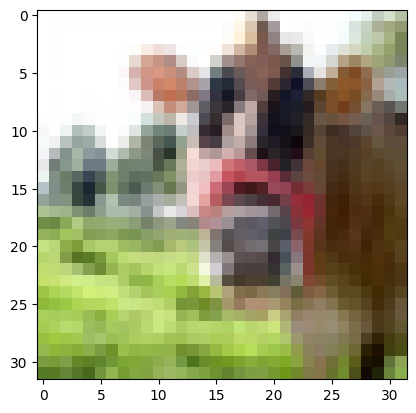

In [6]:
#Plot an image
plt.imshow(trnImg[0])

# A simple neural network
Implementation of a simple neural network with one input layer and one output layer

In [7]:
# simple nn
# reshape images and store in new arrays
size = 32 * 32 * 3
nn_trnImg = trnImg.reshape(trnImg.shape[0],size)
nn_tstImg = tstImg.reshape(tstImg.shape[0],size)

# reshape back
trnImg = trnImg.reshape(trnImg.shape[0],32,32,3)
tstImg = tstImg.reshape(tstImg.shape[0],32,32,3)

def nn(len):
    model = keras.Sequential()
    model.add(layers.Dense(128, activation = 'sigmoid'))
    model.add(layers.Dense(len, activation = 'softmax'))
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
    
    return model

### Run the neural network on finer granularity categories

In [8]:
nn_model_fine = nn(len(fine))

# Train the model
history = nn_model_fine.fit(nn_trnImg, trnLabelFine,
                    batch_size=16,
                    epochs=10,
                    validation_data=(nn_tstImg, tstLabelFine),
                    verbose = 0)

# Evaluate the model
score = nn_model_fine.evaluate(nn_tstImg, tstLabelFine, verbose=0)
print('Finer Granularity Categories')
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Finer Granularity Categories
Test loss: 3.6421382427215576
Test accuracy: 0.1597999930381775


### Run the neural network on super categories

In [9]:
nn_model_coarse = nn(len(coarse))

# Train the model
history = nn_model_coarse.fit(nn_trnImg, trnLabelCoarse,
                    batch_size=16,
                    epochs=10,
                    validation_data=(nn_tstImg, tstLabelCoarse),
                    verbose = 0)

# Evaluate the model
score = nn_model_coarse.evaluate(nn_tstImg, tstLabelCoarse, verbose=0)
print('Super Categories')
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Super Categories
Test loss: 2.4364495277404785
Test accuracy: 0.24950000643730164


# A simple CNN
A simple Convolutional Neural Network with one convolutional layer

In [10]:
# simple cnn
def cnn(len):
    model = keras.Sequential()
    model.add(layers.Conv2D(64, (3, 3), activation = 'relu',input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128,activation = 'sigmoid'))
    model.add(layers.Dense(len,activation='softmax'))
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
    
    return model

### Run the CNN on finer granularity categories

In [11]:
cnn_model_fine = cnn(len(fine))

# Train the model
history =cnn_model_fine.fit(trnImg, trnLabelFine,
                    batch_size=16,
                    epochs=10,
                    validation_data=(tstImg, tstLabelFine),
                    verbose = 0)

# Evaluate the model
score = cnn_model_fine.evaluate(tstImg, tstLabelFine, verbose=0)
print('Finer Granularity Categories')
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Finer Granularity Categories
Test loss: 2.969496726989746
Test accuracy: 0.3303999900817871


### Run the CNN on super categories

In [12]:
cnn_model_coarse = cnn(len(coarse))

# Train the model
history =cnn_model_coarse.fit(trnImg, trnLabelCoarse,
                    batch_size=16,
                    epochs=10,
                    validation_data=(tstImg, tstLabelCoarse),
                    verbose = 0)

# Evaluate the model
score = cnn_model_coarse.evaluate(tstImg, tstLabelCoarse, verbose=0)
print('Super Categories')
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Super Categories
Test loss: 2.166086435317993
Test accuracy: 0.45080000162124634


# Proposed Method

In [47]:
# My method

def classifier(len):
    model = keras.Sequential()
    model.add(layers.Conv2D(64, (3, 3), activation = 'elu',padding='same', input_shape=(32, 32, 3)))
    model.add(layers.Conv2D(64, (3, 3), activation = 'elu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.1))

    model.add(layers.Conv2D(64, (3, 3), activation = 'sigmoid',padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation = 'sigmoid'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.1))

    model.add(layers.Flatten())
    model.add(layers.Dense(128,activation = 'sigmoid'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(len,activation='softmax'))
    model.add(layers.Dropout(0.2))
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
    
    return model

# Run the model on finer granularity categories

In [48]:
my_model_fine = classifier(len(fine))

# Train the model
history = my_model_fine.fit(trnImg, trnLabelFine,
                    batch_size=16,
                    epochs=10,
                    validation_data=(tstImg, tstLabelFine),
                    verbose=0)

# Evaluate the model
score = my_model_fine.evaluate(tstImg, tstLabelFine, verbose=0)
print('Finer Granularity Categories')
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Finer Granularity Categories
Test loss: 2.356829881668091
Test accuracy: 0.438400000333786


In [15]:
my_model_fine.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 30, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 15, 15, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 15, 15, 64)        36928     
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 64)        36928     
                                                      

### Percentage of correct recognition for each category
We use classification_report on the 100 categories to check how well our model perform on each of these categories

In [16]:
label_pred = my_model_fine.predict(tstImg)
label_pred = np.argmax(label_pred, axis = 1)
categories = ["Category {}".format(i) for i in range(100)]
print(classification_report(np.argmax(tstLabelFine, axis=1), label_pred, target_names=categories))

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

  Category 0       0.77      0.68      0.72       100
  Category 1       0.51      0.53      0.52       100
  Category 2       0.23      0.46      0.30       100
  Category 3       0.16      0.20      0.18       100
  Category 4       0.22      0.30      0.26       100
  Category 5       0.33      0.42      0.37       100
  Category 6       0.48      0.46      0.47       100
  Category 7       0.55      0.39      0.46       100
  Category 8       0.81      0.47      0.59       100
  Category 9       0.55      0.54      0.55       100
 Category 10       0.36      0.41      0.38       100
 Category 11       0.32      0.25      0.28       100
 Category 12       0.53      0.33      0.41       100
 Category 13       0.42      0.31      0.36       100
 Category 14       0.33      0.48      0.39       100
 Category 15       0.34      0.40      0.37       100
 Category 16       0.41   

In [17]:
cm = confusion_matrix(np.argmax(tstLabelFine, axis=1), label_pred)
print(cm)

[[68  1  2 ...  0  0  0]
 [ 0 53  0 ...  0  0  0]
 [ 1  2 46 ...  2  5  0]
 ...
 [ 0  0  1 ... 45  0  0]
 [ 0  1 15 ...  1 22  0]
 [ 0  0  3 ...  0  0 31]]


### Plotting graphs

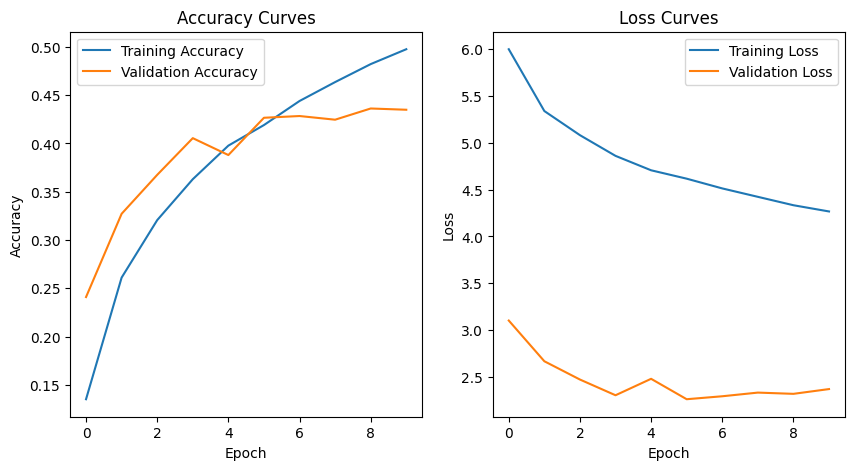

In [18]:
fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Training Accuracy',
           'Validation Accuracy'])
ax[0].set_title('Accuracy Curves')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Training Loss',
           'Validation Loss'])
ax[1].set_title('Loss Curves')
plt.show()

### Display some random images from the dataset with its true and predicted labels

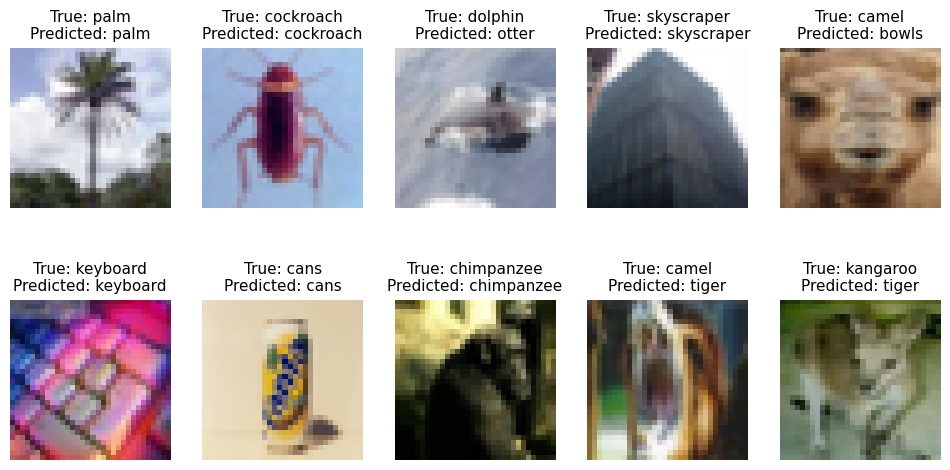

In [19]:

fig, ax = plt.subplots(2, 5, figsize = (12,6))
ax = ax.flatten()

rand_start = np.random.randint(0,len(tstImg)-10)

for i in range(rand_start, rand_start + 10):
    ax[i-rand_start].imshow(tstImg[i])
    ax[i-rand_start].set_title("True: " + fine[np.argmax(tstLabelFine[i])]
                             + "\nPredicted: " + fine[label_pred[i]], 
                            fontsize=11)
    ax[i-rand_start].axis('off')
plt.show()

# Super Categories

In [42]:
my_model_coarse = classifier(len(coarse))

# Train the model
history = my_model_coarse.fit(trnImg, trnLabelCoarse,
                    batch_size=16,
                    epochs=10,
                    validation_data=(tstImg, tstLabelCoarse),
                    verbose = 0)

# Evaluate the model
score = my_model_coarse.evaluate(tstImg, tstLabelCoarse, verbose=0)
print('Super Categories')
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Super Categories
Test loss: 1.584233045578003
Test accuracy: 0.5468000173568726


In [43]:
my_model_coarse.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 conv2d_19 (Conv2D)          (None, 30, 30, 64)        36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 15, 15, 64)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 15, 15, 64)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 15, 15, 64)        36928     
                                                                 
 conv2d_21 (Conv2D)          (None, 13, 13, 64)        36928     
                                                      

### Percentage of correct recognition for each category
We use classification_report on the 20 super categories to check how well our model perform on each of these categories

In [44]:
label_pred = my_model_coarse.predict(tstImg)
label_pred = np.argmax(label_pred, axis = 1)
categories = ["Category {}".format(i) for i in range(20)]
print(classification_report(np.argmax(tstLabelCoarse, axis=1), label_pred, target_names=categories))

313/313 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

  Category 0       0.42      0.51      0.46       500
  Category 1       0.47      0.39      0.42       500
  Category 2       0.71      0.68      0.70       500
  Category 3       0.67      0.60      0.63       500
  Category 4       0.61      0.67      0.63       500
  Category 5       0.45      0.54      0.49       500
  Category 6       0.68      0.62      0.65       500
  Category 7       0.53      0.56      0.54       500
  Category 8       0.43      0.51      0.46       500
  Category 9       0.62      0.74      0.67       500
 Category 10       0.78      0.70      0.74       500
 Category 11       0.45      0.47      0.46       500
 Category 12       0.37      0.45      0.41       500
 Category 13       0.41      0.33      0.37       500
 Category 14       0.66      0.59      0.62       500
 Category 15       0.37      0.36      0.36       500
 Category 16       0.40   

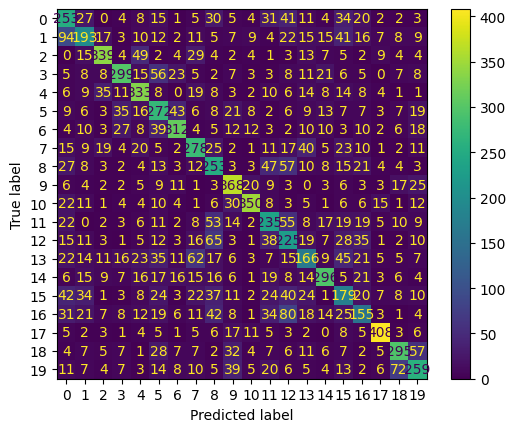

In [45]:
ConfusionMatrixDisplay.from_predictions(np.argmax(tstLabelCoarse, axis=1), label_pred)
plt.show()

### Plotting Graphs

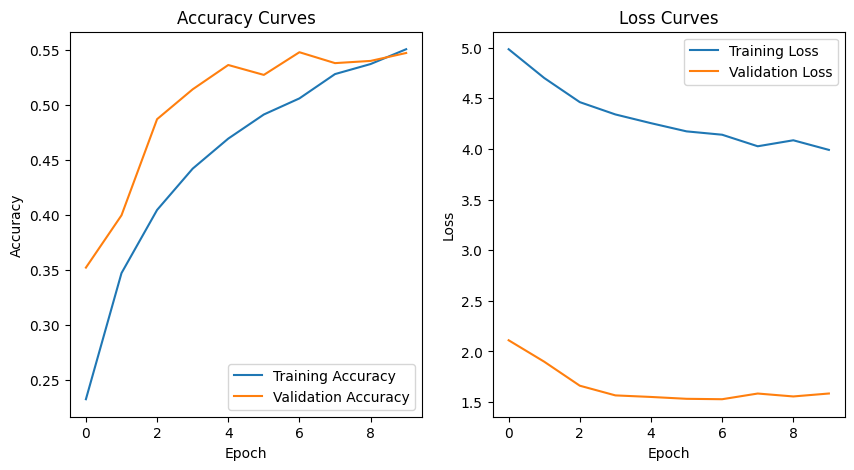

In [46]:
fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Training Accuracy',
           'Validation Accuracy'])
ax[0].set_title('Accuracy Curves')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Training Loss',
           'Validation Loss'])
ax[1].set_title('Loss Curves')
plt.show()

### Display some random images from the dataset with its true and predicted labels

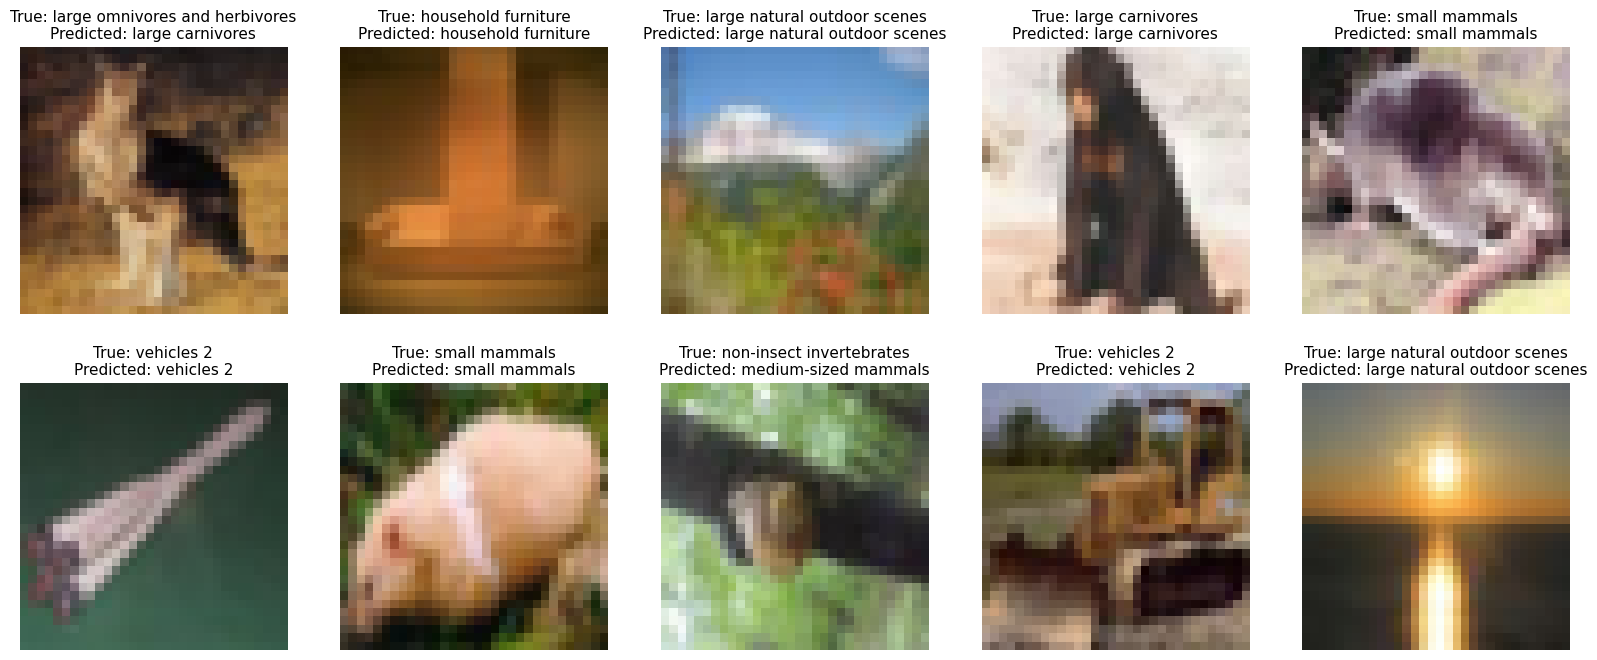

In [29]:
fig, ax = plt.subplots(2, 5, figsize = (20,8))
ax = ax.flatten()

rand_start = np.random.randint(0,len(tstImg)-10)

for i in range(rand_start, rand_start + 10):
    ax[i-rand_start].imshow(tstImg[i])
    ax[i-rand_start].set_title("True: " + coarse[np.argmax(tstLabelCoarse[i])]
                             + "\nPredicted: " + coarse[label_pred[i]], 
                            fontsize=11)
    ax[i-rand_start].axis('off')
plt.show()